In [1]:
import argparse
import os
import random

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from tqdm import tqdm

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import save_image

from pope_loader import POPEDataSet
from minigpt4.common.dist_utils import get_rank
from minigpt4.models import load_preprocess

from minigpt4.common.config import Config
from minigpt4.common.dist_utils import get_rank
from minigpt4.common.registry import registry

# imports modules for registration
from minigpt4.datasets.builders import *
from minigpt4.models import *
from minigpt4.processors import *
from minigpt4.runners import *
from minigpt4.tasks import *

from PIL import Image
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import json


MODEL_EVAL_CONFIG_PATH = {
    "minigpt4": "eval_configs/minigpt4_eval.yaml",
    "instructblip": "eval_configs/instructblip_eval.yaml",
    "lrv_instruct": "eval_configs/lrv_instruct_eval.yaml",
    "shikra": "eval_configs/shikra_eval.yaml",
    "llava-1.5": "eval_configs/llava-1.5_eval.yaml",
}

POPE_PATH = {
    "random": "coco_pope/coco_pope_random.json",
    "popular": "coco_pope/coco_pope_popular.json",
    "adversarial": "coco_pope/coco_pope_adversarial.json",
}

INSTRUCTION_TEMPLATE = {
    "minigpt4": "###Human: <Img><ImageHere></Img> <question> ###Assistant:",
    "instructblip": "<ImageHere><question>",
    "lrv_instruct": "###Human: <Img><ImageHere></Img> <question> ###Assistant:",
    "shikra": "USER: <im_start><ImageHere><im_end> <question> ASSISTANT:",
    "llava-1.5": "USER: <ImageHere> <question> ASSISTANT:"
}


def setup_seeds(config):
    seed = config.run_cfg.seed + get_rank()

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True





parser = argparse.ArgumentParser(description="POPE-Adv evaluation on LVLMs.")
parser.add_argument("--model", type=str, help="model")
parser.add_argument("--gpu-id", type=int, help="specify the gpu to load the model.")
parser.add_argument(
    "--options",
    nargs="+",
    help="override some settings in the used config, the key-value pair "
    "in xxx=yyy format will be merged into config file (deprecate), "
    "change to --cfg-options instead.",
)
parser.add_argument("--data_path", type=str, default="/mnt/petrelfs/share_data/wangjiaqi/mllm-data-alg/COCO_2014/ori/val2014/val2014/", help="data path")
parser.add_argument("--batch_size", type=int, help="batch size")
parser.add_argument("--num_workers", type=int, default=2, help="num workers")
args = parser.parse_known_args()[0]


args.model = "llava-1.5"
# args.model = "instructblip"
# args.model = "minigpt4"
# args.model = "shikra"
args.gpu_id = "0"
args.batch_size = 1


os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
args.cfg_path = MODEL_EVAL_CONFIG_PATH[args.model]
cfg = Config(args)
setup_seeds(cfg)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# ========================================
#             Model Initialization
# ========================================
print('Initializing Model')

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to(device)
model.eval()
processor_cfg = cfg.get_config().preprocess
processor_cfg.vis_processor.eval.do_normalize = False
vis_processors, txt_processors = load_preprocess(processor_cfg)
print(vis_processors["eval"].transform)
print("Done!")

mean = (0.48145466, 0.4578275, 0.40821073)
std = (0.26862954, 0.26130258, 0.27577711)
norm = transforms.Normalize(mean, std)



Initializing Model


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14-336 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.1.self_attn.q_proj.weight', 'text_model.encoder.layers.6.layer_norm2.weight', 'text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.4.mlp.fc1.weight', 'text_model.encoder.layers.7.self_attn.q_proj.bias', 'text_projection.weight', 'text_model.encoder.layers.2.mlp.fc1.bias', 'text_model.encoder.layers.1.mlp.fc1.bias', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.8.self_attn.q_proj.bias', 'text_model.encoder.layers.8.layer_norm2.weight', 'text_model.encoder.layers.9.self_attn.q_proj.bias', 'text_model.encoder.layers.4.self_attn.k_proj.weight', 'text_model.encoder.layers.3.mlp.fc1.weight', 'text_model.encoder.layers.3.layer_norm2.bias', 'text_model.encoder.layers.10.layer_no

CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

Done!


In [2]:
img_files = [
    "COCO_val2014_000000175440.jpg",
    "COCO_val2014_000000063154.jpg",
]

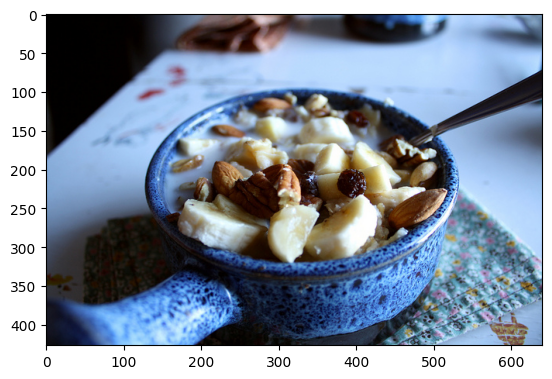

Original output:
The image features a blue bowl filled with a delicious mixture of bananas, nuts, and oatmeal. The bowl is placed on a dining table, and a spoon is resting inside the bowl, ready to be used for enjoying the meal.

In addition to the bowl of food, there are a few other items on the table. A bottle can be seen on the left side of the table, while a cup is positioned towards the top right corner. A book is also present on the right side of the table, adding to the cozy atmosphere of the scene.


OPERA's output:
The image features a blue bowl filled with a delicious mixture of bananas, nuts, and oatmeal. The bowl is placed on a dining table, and a spoon is resting inside the bowl, ready to be used. The bananas are scattered throughout the bowl, with some closer to the top and others near the bottom. The nuts and oatmeal complement the bananas, creating a visually appealing and appetizing dish.


In [3]:
img = img_files[0]
image_path = args.data_path + img
raw_image = Image.open(image_path)
plt.imshow(raw_image)
plt.show()
raw_image = raw_image.convert("RGB")
image = vis_processors["eval"](raw_image).unsqueeze(0)
image = image.to(device)

qu = "Please describe this image in detail."
template = INSTRUCTION_TEMPLATE[args.model]
qu = template.replace("<question>", qu)


with torch.inference_mode():
    with torch.no_grad():
        out = model.generate(
            {"image": norm(image), "prompt":qu}, 
            use_nucleus_sampling=False, 
            num_beams=5,
            max_new_tokens=512,
        )
print("Original output:")
print(out[0])
print("\n")

with torch.inference_mode():
    with torch.no_grad():
        out1 = model.generate(
            {"image": norm(image), "prompt":qu}, 
            use_nucleus_sampling=False, 
            num_beams=5,
            max_new_tokens=512,
            output_attentions=True,
            opera_decoding=True,
            scale_factor=50,
            threshold=15.0,
            num_attn_candidates=5,
        )
print("OPERA's output:")
print(out1[0])

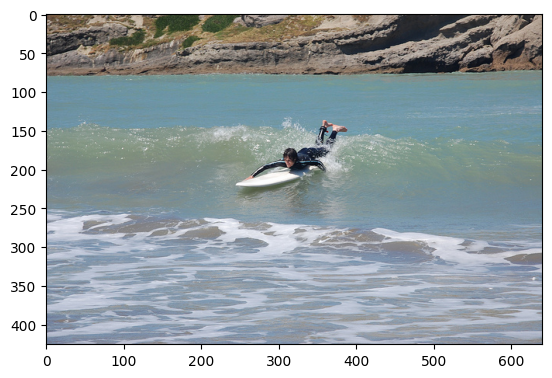

Original output:
The image captures a man skillfully riding a surfboard on a wave in the ocean. He is wearing a wetsuit and appears to be enjoying the thrill of surfing. The surfboard is positioned in the middle of the scene, with the man skillfully maintaining his balance as he glides through the water.

There are a few other people in the background, but they are not the main focus of the scene. The main focus is on the man riding the wave on his surfboard, showcasing his talent and passion for the sport.


OPERA's output:
The image captures a man skillfully riding a surfboard on a wave in the ocean. He is wearing a wetsuit and appears to be enjoying the thrill of surfing. The surfboard is positioned in the middle of the scene, with the man skillfully balancing on it as he navigates the wave.


In [4]:
img = img_files[1]
image_path = args.data_path + img
raw_image = Image.open(image_path)
plt.imshow(raw_image)
plt.show()
raw_image = raw_image.convert("RGB")
image = vis_processors["eval"](raw_image).unsqueeze(0)
image = image.to(device)

qu = "Please describe this image in detail."
template = INSTRUCTION_TEMPLATE[args.model]
qu = template.replace("<question>", qu)


with torch.inference_mode():
    with torch.no_grad():
        out = model.generate(
            {"image": norm(image), "prompt":qu}, 
            use_nucleus_sampling=False, 
            num_beams=5,
            max_new_tokens=512,
        )
print("Original output:")
print(out[0])
print("\n")

with torch.inference_mode():
    with torch.no_grad():
        out1 = model.generate(
            {"image": norm(image), "prompt":qu}, 
            use_nucleus_sampling=False, 
            num_beams=5,
            max_new_tokens=512,
            output_attentions=True,
            opera_decoding=True,
            scale_factor=50,
            threshold=15.0,
            num_attn_candidates=5,
        )
print("OPERA's output:")
print(out1[0])